In [1]:
%run '/content/drive/MyDrive/Colab Notebooks/ROUND_3/Dataset_Generator.py'
import csv
import os
import random
import struct
import time
from typing import List, Tuple

# ==============================================================================
# ASCON CONSTANTS AND CORE FUNCTIONS
# ==============================================================================

# ASCON round constants for 12 rounds
ASCON_RC = [
    0xf0, 0xe1, 0xd2, 0xc3, 0xb4, 0xa5, 0x96, 0x87, 0x78, 0x69, 0x5a, 0x4b
]

# ASCON 5-bit S-box
ASCON_SBOX = [
    0x4, 0xB, 0x1F, 0x14, 0x1A, 0x15, 0x9, 0x2,
    0x1B, 0x5, 0x8, 0x12, 0x1D, 0x3, 0x6, 0x1C,
    0x1E, 0x13, 0x7, 0xE, 0x0, 0xD, 0x11, 0x18,
    0x10, 0xC, 0x1, 0x19, 0x16, 0xA, 0xF, 0x17
]

# Used to ensure values stay within 64-bit words (bit masking).
MASK_64 = 0xFFFFFFFFFFFFFFFF

def right_rotate(x: int, r: int) -> int:
    """Right rotation (circular shift) by r bits of a 64-bit word."""
    return ((x >> r) | (x << (64 - r))) & MASK_64

def bytes_to_state(data: bytes) -> List[int]:
    """Convert 40 bytes (320 bits) to 5 64-bit words."""
    if len(data) != 40:
        raise ValueError(f"Input must be 40 bytes, got {len(data)} bytes")

    state = []
    for i in range(5):
        # Extract 8 bytes for each 64-bit word
        word_bytes = data[i*8:(i+1)*8]
        state.append(int.from_bytes(word_bytes, byteorder='big'))
    return state

def state_to_bytes(state: List[int]) -> bytes:
    """Convert 5 64-bit words to 40 bytes."""
    result = b''
    for word in state:
        result += word.to_bytes(8, byteorder='big')
    return result

def ascon_permutation(state: List[int], rounds: int) -> None:
    """
    ASCON core permutation.
    """
    start_round = 12 - rounds
    for round_idx in range(start_round, 12):
        # Addition of Constants
        state[2] ^= ASCON_RC[round_idx]

        # Substitution Layer
        temp_state = [0, 0, 0, 0, 0]

        for bit_pos in range(64):
            slice_val = 0
            for word_idx in range(5):
                bit = (state[word_idx] >> bit_pos) & 0x1
                slice_val |= (bit << (4 - word_idx))

            sbox_output = ASCON_SBOX[slice_val]

            for word_idx in range(5):
                bit = (sbox_output >> (4 - word_idx)) & 0x1
                if bit:
                    temp_state[word_idx] |= (1 << bit_pos)

        state[:] = temp_state

        # Linear Diffusion Layer
        state[0] = state[0] ^ right_rotate(state[0], 19) ^ right_rotate(state[0], 28)
        state[1] = state[1] ^ right_rotate(state[1], 61) ^ right_rotate(state[1], 39)
        state[2] = state[2] ^ right_rotate(state[2], 1) ^ right_rotate(state[2], 6)
        state[3] = state[3] ^ right_rotate(state[3], 10) ^ right_rotate(state[3], 17)
        state[4] = state[4] ^ right_rotate(state[4], 7) ^ right_rotate(state[4], 41)

        # Ensure 64-bit truncation
        for i in range(5):
            state[i] &= MASK_64

# ==============================================================================
# PERMUTATION WRAPPER FUNCTION
# ==============================================================================

def apply_ascon_permutation(data: bytes, rounds: int) -> bytes:
    """
    Apply ASCON permutation to 40-byte data for the specified number of rounds.
    This is NOT full ASCON encryption - just the permutation for analysis.
    """
    # Convert data to state
    state = bytes_to_state(data)

    # Apply permutation
    ascon_permutation(state, rounds)

    # Convert state back to bytes
    return state_to_bytes(state)

# ==============================================================================
# HELPER FUNCTIONS
# ==============================================================================

def generate_random_bytes(length: int) -> bytes:
    """Generate cryptographically secure random bytes."""
    return os.urandom(length)

def xor_bytes(b1: bytes, b2: bytes) -> bytes:
    """XOR two byte strings of equal length."""
    return bytes(x ^ y for x, y in zip(b1, b2))

def bytes_to_decimal_string(b: bytes) -> str:
    """Convert bytes to comma-separated decimal string for CSV storage."""
    return ','.join(map(str, b))

# ==============================================================================
# DATASET GENERATION
# ==============================================================================

def generate_dataset(N_per_class: int, delta: bytes, data_rounds: int) -> List[Tuple[bytes, bytes, bytes, int]]:
    """
    Generate dataset following Algorithm 1 exactly with proper usage.
    """
    print(f"Generating dataset for {data_rounds}-round ASCON permutation...")
    print(f"Samples per class: {N_per_class} (Total: {2 * N_per_class})")
    print(f"Input Difference δ: {delta.hex()}")

    start_time = time.time()
    dataset = []

    for label in [0, 1]:
        print(f"\nGenerating {N_per_class} Label {label} samples...")

        for i in range(N_per_class):
            if (i + 1) % 5000 == 0:
                print(f"  Label {label} progress: {i + 1}/{N_per_class}")

            # Generate random plaintext P1
            P1 = generate_random_bytes(40)   # 320-bit input

            # Apply permutation to P1 to get C1
            C1 = apply_ascon_permutation(P1, data_rounds)

            if label == 0:  # Random difference (Label 0)
                # Generate completely random P2
                P2 = generate_random_bytes(40)
                current_label = 0
            else:  # Real difference (Label 1)
                # Apply the input difference: P2 = P1 ⊕ δ
                P2 = xor_bytes(P1, delta)
                current_label = 1

            # Apply permutation to P2 to get C2
            C2 = apply_ascon_permutation(P2, data_rounds)

            # Compute C_XOR = C1 ⊕ C2
            C_XOR = xor_bytes(C1, C2)

            dataset.append((C1, C2, C_XOR, current_label))

    random.shuffle(dataset)

    end_time = time.time()
    print(f"\nGeneration complete in {end_time - start_time:.2f} seconds.")

    return dataset

def save_dataset_to_csv(dataset: List[Tuple[bytes, bytes, bytes, int]], filename: str):
    """
    Save the dataset to CSV with columns: C1, C2, C1_xor_C2, Label
    """
    print(f"\nSaving dataset to {filename}...")

    with open(filename, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['C1', 'C2', 'C1_xor_C2', 'Label'])
        writer.writeheader()

        for C1, C2, C_XOR, label in dataset:
            writer.writerow({
                'C1': bytes_to_decimal_string(C1),
                'C2': bytes_to_decimal_string(C2),
                'C1_xor_C2': bytes_to_decimal_string(C_XOR),
                'Label': label
            })

    print(f"Dataset saved with {len(dataset)} samples.")

def validate_dataset(dataset: List[Tuple]):
    """Validate that dataset has exactly 50,000 samples per class."""
    label_0_count = sum(1 for _, _, _, label in dataset if label == 0)
    label_1_count = sum(1 for _, _, _, label in dataset if label == 1)

    print(f"\nDataset Validation:")
    print(f"  Label 0 samples: {label_0_count}")
    print(f"  Label 1 samples: {label_1_count}")
    print(f"  Total samples: {len(dataset)}")

    if label_0_count == label_1_count == 50000:
        print("Dataset is perfect (50,000 per class)")
        return True
    else:
        print("Dataset is not correctly")
        return False

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == '__main__':
    # Configuration
    N_PER_CLASS = 50000
    DATA_ROUNDS = 3
    OUTPUT_FILENAME = f'ascon_dataset_{DATA_ROUNDS}.csv'

    # Define input difference δ (40 bytes)
    DELTA = b'\x00\x00\x00\x00\x00\x00\x00\x01' + b'\x00' * 32

    print("=" * 70)
    print("ASCON DIFFERENTIAL DATASET GENERATOR")
    print("=" * 70)
    print(f"Target Rounds: {DATA_ROUNDS}")
    print(f"Samples per class: {N_PER_CLASS}")
    print(f"Total Samples: {2 * N_PER_CLASS}")
    print(f"Output File: {OUTPUT_FILENAME}")
    print("=" * 70)

    # Generate dataset
    dataset = generate_dataset(N_PER_CLASS, DELTA, DATA_ROUNDS)

    # Validate
    if not validate_dataset(dataset):
        print("Dataset generation failed!")
        exit(1)

    # Save to CSV
    save_dataset_to_csv(dataset, OUTPUT_FILENAME)

    # Final statistics
    label_0_count = sum(1 for _, _, _, label in dataset if label == 0)
    label_1_count = sum(1 for _, _, _, label in dataset if label == 1)

    print("\n" + "=" * 60)
    print("DATASET GENERATION COMPLETE")
    print("=" * 60)
    print(f"Label 0 (Random pairs):    {label_0_count:>6} samples")
    print(f"Label 1 (Differential pairs): {label_1_count:>6} samples")
    print(f"Total Samples:            {len(dataset):>6}")
    print("=" * 60)

ASCON DIFFERENTIAL DATASET GENERATOR
Target Rounds: 3
Samples per class: 50000
Total Samples: 100000
Output File: ascon_dataset_3.csv
Generating dataset for 3-round ASCON permutation...
Samples per class: 50000 (Total: 100000)
Input Difference δ: 00000000000000010000000000000000000000000000000000000000000000000000000000000000

Generating 50000 Label 0 samples...
  Label 0 progress: 5000/50000
  Label 0 progress: 10000/50000
  Label 0 progress: 15000/50000
  Label 0 progress: 20000/50000
  Label 0 progress: 25000/50000
  Label 0 progress: 30000/50000
  Label 0 progress: 35000/50000
  Label 0 progress: 40000/50000
  Label 0 progress: 45000/50000
  Label 0 progress: 50000/50000

Generating 50000 Label 1 samples...
  Label 1 progress: 5000/50000
  Label 1 progress: 10000/50000
  Label 1 progress: 15000/50000
  Label 1 progress: 20000/50000
  Label 1 progress: 25000/50000
  Label 1 progress: 30000/50000
  Label 1 progress: 35000/50000
  Label 1 progress: 40000/50000
  Label 1 progress: 4500

In [2]:
%run '/content/drive/MyDrive/Colab Notebooks/ROUND_3/data_processor.py'
"""
data_processor.py - Prepares ASCON balanced differential dataset for ML models.
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Tuple
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ASCON state: 5 words × 64 bits = 320 bits = 40 bytes
INPUT_LENGTH = 320
NUM_CLASSES = 2  # Binary classification (Differential vs Random)

def decimal_string_to_binary_vector(decimal_string: str, feature_select_start_bit: int = 0, feature_select_end_bit: int = INPUT_LENGTH) -> np.ndarray:

    try:
        # Convert directly to numpy array for efficiency
        bytes_array = np.array([int(b) for b in decimal_string.split(',')], dtype=np.uint8)
    except ValueError as e:
        raise ValueError(f"Error parsing decimal string: {e}")

    if len(bytes_array) != 40:
        raise ValueError(f"Expected 40 bytes for 320-bit state, got {len(bytes_array)} bytes")

    # Convert bytes to binary representation efficiently
    binary_array = np.unpackbits(bytes_array).astype(np.float32)

    # Apply feature selection
    selected_features = binary_array[feature_select_start_bit:feature_select_end_bit]
    return selected_features.reshape(-1, 1)

def load_and_prepare_data(
    file_path: str,
    feature_column: str = 'C1_xor_C2',
    test_size: float = 0.15,
    val_size: float = 0.15,
    feature_select_start_bit: int = 0,
    feature_select_end_bit: int = INPUT_LENGTH,
    random_state: int = 42,
    use_multiple_features: bool = False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int]:

    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        logger.error(f"Dataset file not found at {file_path}")
        raise
    except Exception as e:
        logger.error(f"Error reading CSV file: {e}")
        raise

    logger.info(f"Loading data from {file_path}...")
    logger.info(f"Dataset size: {len(df)} samples")

    # Check column names
    EXPECTED_COLUMNS = ['C1', 'C2', 'C1_xor_C2', 'Label']
    LABEL_COLUMN = 'Label'

    missing_columns = [col for col in EXPECTED_COLUMNS if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing expected columns: {missing_columns}")

    # Display dataset statistics
    label_counts = df[LABEL_COLUMN].value_counts().sort_index()
    logger.info(f"Label distribution: Class 0: {label_counts.get(0, 0)}, Class 1: {label_counts.get(1, 0)}")

    # Check for perfect balance (50,000 each)
    if len(label_counts) == 2 and label_counts[0] == label_counts[1] == 50000:
        logger.info(" Dataset is perfectly balanced (50,000 samples per class)")
    else:
        logger.warning(" Dataset is not perfectly balanced")

    # Feature preparation
    if use_multiple_features:
        logger.info("Using multiple feature columns for enhanced training...")
        X_list = []

        for _, row in df.iterrows():
            try:
                # Combine features from multiple columns
                features_combined = []

                # Use C1_xor_C2 as primary feature
                primary_feature = decimal_string_to_binary_vector(
                    row['C1_xor_C2'], feature_select_start_bit, feature_select_end_bit
                )
                features_combined.append(primary_feature.flatten())

                # Optionally add C1 and C2 individually (first few bits)
                secondary_bits = 64  # Use first 64 bits of each
                c1_feature = decimal_string_to_binary_vector(
                    row['C1'], 0, secondary_bits
                )
                c2_feature = decimal_string_to_binary_vector(
                    row['C2'], 0, secondary_bits
                )
                features_combined.extend([c1_feature.flatten(), c2_feature.flatten()])

                combined_features = np.concatenate(features_combined)
                X_list.append(combined_features.reshape(-1, 1))

            except Exception as e:
                logger.warning(f"Failed to convert sample: {e}")
                continue
    else:
        logger.info(f"Using single feature column: '{feature_column}'")
        X_list = []

        for decimal_str in df[feature_column]:
            try:
                binary_vec = decimal_string_to_binary_vector(
                    decimal_str, feature_select_start_bit, feature_select_end_bit
                )
                X_list.append(binary_vec)
            except Exception as e:
                logger.warning(f"Failed to convert sample: {e}")
                continue

    X = np.array(X_list, dtype=np.float32)
    actual_input_length = X.shape[1]

    logger.info(f"Feature matrix shape: {X.shape}")
    logger.info(f"Actual input length: {actual_input_length} bits")

    # Label preparation
    Y = df[LABEL_COLUMN].values.reshape(-1, 1).astype(np.float32)

    # Ensure we have the same number of samples in X and Y
    if len(X) != len(Y):
        min_len = min(len(X), len(Y))
        X = X[:min_len]
        Y = Y[:min_len]
        logger.warning(f"Adjusted dataset size to {min_len} due to conversion issues")

    # Data splitting (70% train, 15% validation, 15% test)
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y, test_size=test_size + val_size, random_state=random_state, stratify=Y
    )

    # Split temp into validation and test
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, Y_val, Y_test = train_test_split(
        X_temp, Y_temp, test_size=val_ratio, random_state=random_state, stratify=Y_temp
    )

    logger.info(f"\nDataset split:")
    logger.info(f"  Training:   {X_train.shape[0]} samples")
    logger.info(f"  Validation: {X_val.shape[0]} samples")
    logger.info(f"  Test:       {X_test.shape[0]} samples")

    # Verify split balance
    train_balance = np.unique(Y_train, return_counts=True)
    val_balance = np.unique(Y_val, return_counts=True)
    test_balance = np.unique(Y_test, return_counts=True)

    logger.info(f"Train balance: Class 0: {train_balance[1][0]}, Class 1: {train_balance[1][1]}")
    logger.info(f"Val balance: Class 0: {val_balance[1][0]}, Class 1: {val_balance[1][1]}")
    logger.info(f"Test balance: Class 0: {test_balance[1][0]}, Class 1: {test_balance[1][1]}")

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, actual_input_length, NUM_CLASSES

def prepare_for_lgbm(
    X_train_3d: np.ndarray, X_val_3d: np.ndarray, X_test_3d: np.ndarray,
    Y_train_3d: np.ndarray, Y_val_3d: np.ndarray, Y_test_3d: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Flattens 3D data to 2D for tree-based models."""
    X_train_flat = X_train_3d.reshape(X_train_3d.shape[0], -1)
    X_val_flat = X_val_3d.reshape(X_val_3d.shape[0], -1)
    X_test_flat = X_test_3d.reshape(X_test_3d.shape[0], -1)

    Y_train_flat = Y_train_3d.ravel()
    Y_val_flat = Y_val_3d.ravel()
    Y_test_flat = Y_test_3d.ravel()

    logger.info(f"Flattened shapes - X_train: {X_train_flat.shape}, Y_train: {Y_train_flat.shape}")

    return X_train_flat, X_val_flat, X_test_flat, Y_train_flat, Y_val_flat, Y_test_flat

def get_feature_importance_names(actual_input_length: int, use_multiple_features: bool = False) -> list:
    """
    Returns feature names for interpretability.
    """
    if use_multiple_features:
        # For multiple features, create descriptive names
        names = []
        names.extend([f"xor_bit_{i}" for i in range(actual_input_length)])
        names.extend([f"c1_bit_{i}" for i in range(64)])  # First 64 bits of C1
        names.extend([f"c2_bit_{i}" for i in range(64)])  # First 64 bits of C2
        return names
    else:
        return [f"bit_{i}" for i in range(actual_input_length)]

In [3]:
%run '/content/drive/MyDrive/Colab Notebooks/ROUND_3/LightGBM.ipynb'
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from data_processor import load_and_prepare_data, prepare_for_lgbm

# Configuration
DATA_FILENAME = 'ascon_dataset_3.csv'
DATA_ROUNDS = 3
DISTINGUISHER_THRESHOLD = 0.50
N_INPUT_DIFFERENCES = 2  # Number of input differences considered

def calculate_tpr_tnr(y_true, y_pred):
    """
    Calculate True Positive Rate (TPR) and True Negative Rate (TNR)
    """
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)

    return TPR, TNR

def train_lightgbm_distinguisher():
    """Train and evaluate LightGBM distinguisher."""

    print("Loading data for LightGBM...")
    X_train, X_val, X_test, Y_train, Y_val, Y_test, input_len, _ = load_and_prepare_data(DATA_FILENAME)

    # Prepare data for LightGBM
    X_train_flat, X_val_flat, X_test_flat, Y_train_flat, Y_val_flat, Y_test_flat = prepare_for_lgbm(
        X_train, X_val, X_test, Y_train, Y_val, Y_test
    )

    # LightGBM dataset
    train_data = lgb.Dataset(X_train_flat, label=Y_train_flat)
    val_data = lgb.Dataset(X_val_flat, label=Y_val_flat, reference=train_data)

    # OPTIMIZED Hyperparameters for higher accuracy
    params = {
        'objective': 'binary',
        'metric': ['binary_logloss', 'binary_error', 'auc'],
        'boosting_type': 'gbdt',
        'num_leaves': 512,
        'learning_rate': 0.01,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 10,
        'verbose': -1,
        'max_depth': 12,
        'min_data_in_leaf': 10,
        'min_split_gain': 0.0001,
        'reg_alpha': 0.05,
        'reg_lambda': 0.05,
        'max_bin': 512,
        'min_child_weight': 0.001,
        'subsample_for_bin': 50000,
        'subsample': 0.8,
        'subsample_freq': 1,
    }

    print("\nTraining LightGBM model with parameters...")
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,  # Increased from 1000 for more iterations
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),  # Increased patience
            lgb.log_evaluation(period=100)
        ]
    )

    # Calculate predictions and metrics
    # Training predictions
    y_train_pred_proba = model.predict(X_train_flat)
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    train_accuracy = accuracy_score(Y_train_flat, y_train_pred)

    # Calculate training loss (binary cross-entropy)
    train_loss = -np.mean(Y_train_flat * np.log(y_train_pred_proba + 1e-15) + (1 - Y_train_flat) * np.log(1 - y_train_pred_proba + 1e-15))

    # Test predictions
    y_test_pred_proba = model.predict(X_test_flat)
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    test_accuracy = accuracy_score(Y_test_flat, y_test_pred)

    # Calculate test loss
    test_loss = -np.mean(Y_test_flat * np.log(y_test_pred_proba + 1e-15) + (1 - Y_test_flat) * np.log(1 - y_test_pred_proba + 1e-15))

    # Calculate TPR and TNR
    tpr, tnr = calculate_tpr_tnr(Y_test_flat, y_test_pred)

    # Display only the required metrics
    print("\n" + "="*60)
    print("LIGHTGBM RESULTS")
    print("="*60)
    print(f"Training Accuracy:  {train_accuracy:.4f}")
    print(f"Training Loss:      {train_loss:.4f}")
    print(f"Testing Accuracy:   {test_accuracy:.4f}")
    print(f"Testing Loss:       {test_loss:.4f}")
    print(f"TPR:                {tpr:.4f}")
    print(f"TNR:                {tnr:.4f}")

    # Distinguisher found/not found logic
    print("\n" + "="*60)
    print("DISTINGUISHER EVALUATION")
    print("="*60)

    if train_accuracy > 1/N_INPUT_DIFFERENCES:
        if test_accuracy > 1/N_INPUT_DIFFERENCES:
            print(" DISTINGUISHER FOUND")
        else:
            print(" DISTINGUISHER NOT FOUND")
    else:
        print(" DISTINGUISHER NOT FOUND")

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Threshold (1/{N_INPUT_DIFFERENCES}): {1/N_INPUT_DIFFERENCES:.4f}")
    print("="*60)

    return train_accuracy, test_accuracy, train_loss, test_loss, tpr, tnr

if __name__ == '__main__':
    train_lightgbm_distinguisher()

Loading data for LightGBM...

Training LightGBM model with parameters...
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.20316	train's binary_error: 0	train's auc: 1	valid's binary_logloss: 0.203168	valid's binary_error: 0	valid's auc: 1
Early stopping, best iteration is:
[3]	train's binary_logloss: 0.66392	train's binary_error: 0.000114286	train's auc: 0.999986	valid's binary_logloss: 0.663927	valid's binary_error: 0.000266667	valid's auc: 1

LIGHTGBM RESULTS
Training Accuracy:  0.9999
Training Loss:      0.6639
Testing Accuracy:   0.9997
Testing Loss:       0.6639
TPR:                1.0000
TNR:                0.9993

DISTINGUISHER EVALUATION
 DISTINGUISHER FOUND
Training Accuracy: 0.9999
Test Accuracy: 0.9997
Threshold (1/2): 0.5000


Loading and preparing data...

Building Compact CNN model for input length: 320

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 320, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 320, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 320, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 320, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 320, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 160, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 160, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 160, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 160, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 61,377 (239.75 KB)

 Trainable params: 60,673 (237.00 KB)

 Non-trainable params: 704 (2.75 KB)


Starting training...
Epoch 1/50
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8397 - loss: 0.3634
Epoch 1: val_accuracy improved from -inf to 0.67567, saving model to best_compact_cnn.keras
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 179s 119ms/step - accuracy: 0.8397 - loss: 0.3634 - val_accuracy: 0.6757 - val_loss: 0.8546 - learning_rate: 8.0000e-04
Epoch 2/50
1458/1459 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8862 - loss: 0.2741
Epoch 2: val_accuracy did not improve from 0.67567
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 168s 115ms/step - accuracy: 0.8862 - loss: 0.2741 - val_accuracy: 0.6403 - val_loss: 0.9407 - learning_rate: 8.0000e-04
Epoch 3/50
1458/1459 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9003 - loss: 0.2415
Epoch 3: val_accuracy improved from 0.67567 to 0.84293, saving model to best_compact_cnn.keras
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 171s 117ms/step - accuracy: 0.9003 - loss: 0.2415 - val_accuracy: 0.8429 - val_loss: 0.3430 - learning_rate: 8.0000e-04
Epoch 4/50
1458/1

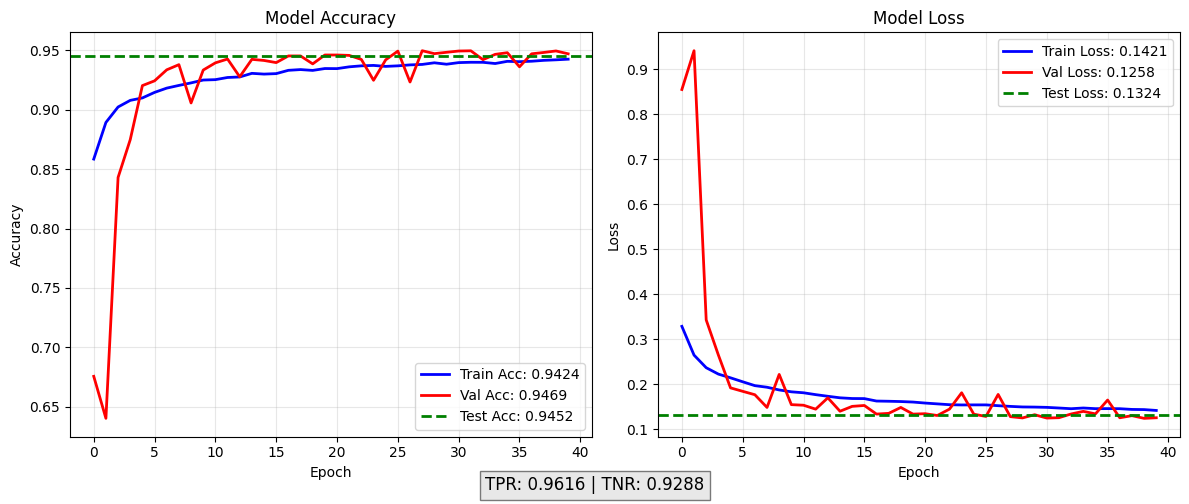


DISTINGUISHER EVALUATION
 DISTINGUISHER FOUND
Training Accuracy: 0.9424
Test Accuracy: 0.9452
Threshold (1/2): 0.5000


In [4]:
%run '/content/drive/MyDrive/Colab Notebooks/ROUND_3/CNN.ipynb'
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from data_processor import load_and_prepare_data
from sklearn.metrics import confusion_matrix

# Configuration
DATA_FILENAME = 'ascon_dataset_3.csv'
DATA_ROUNDS = 3
INPUT_BITS = 320
DISTINGUISHER_THRESHOLD = 0.50
EPOCHS = 50
BATCH_SIZE = 48
INITIAL_LR = 0.0008
N_INPUT_DIFFERENCES = 2  # Number of input differences considered

def build_compact_cnn(input_length: int) -> Model:

    input_layer = Input(shape=(input_length, 1))
    x = input_layer

    # Block 1 - Initial feature extraction
    x = Conv1D(filters=32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # Block 2 - Feature expansion
    x = Conv1D(filters=64, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # Block 3 - Deeper features
    x = Conv1D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # Global pooling
    x = GlobalAveragePooling1D()(x)

    # Compact classification head
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=INITIAL_LR),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def calculate_tpr_tnr(y_true, y_pred):
    """
    Calculate True Positive Rate (TPR) and True Negative Rate (TNR)
    """
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)

    return TPR, TNR

def plot_simple_training_history(history, test_accuracy, test_loss, tpr, tnr):
    """
    Plot only accuracy and loss graphs with TPR/TNR values
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Get final training accuracy and loss
    final_train_accuracy = history.history['accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label=f'Train Acc: {final_train_accuracy:.4f}', linewidth=2, color='blue')
    ax1.plot(history.history['val_accuracy'], label=f'Val Acc: {final_val_accuracy:.4f}', linewidth=2, color='red')
    ax1.axhline(y=test_accuracy, color='green', linestyle='--', linewidth=2, label=f'Test Acc: {test_accuracy:.4f}')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label=f'Train Loss: {final_train_loss:.4f}', linewidth=2, color='blue')
    ax2.plot(history.history['val_loss'], label=f'Val Loss: {final_val_loss:.4f}', linewidth=2, color='red')
    ax2.axhline(y=test_loss, color='green', linestyle='--', linewidth=2, label=f'Test Loss: {test_loss:.4f}')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Add TPR and TNR as text on the plot
    plt.figtext(0.5, 0.01, f'TPR: {tpr:.4f} | TNR: {tnr:.4f}',
                ha='center', fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

    plt.savefig('cnn_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_cnn_distinguisher():
    """Main function to run the CNN distinguisher experiment."""

    print("Loading and preparing data...")
    X_train, X_val, X_test, Y_train, Y_val, Y_test, input_len, _ = load_and_prepare_data(DATA_FILENAME)

    print(f"\nBuilding Compact CNN model for input length: {input_len}")
    model = build_compact_cnn(input_len)

    print("\nModel Summary:")
    model.summary()

    # Enhanced callbacks
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=12, verbose=1, restore_best_weights=True, mode='max'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1),
        ModelCheckpoint('best_compact_cnn.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]

    print("\nStarting training...")
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

    # Load best model for evaluation
    best_model = tf.keras.models.load_model('best_compact_cnn.keras')

    print("\nEvaluating best model on test data...")
    test_results = best_model.evaluate(X_test, Y_test, verbose=0)
    test_loss, test_accuracy = test_results[0], test_results[1]

    # Predictions for TPR/TNR calculation
    y_pred = best_model.predict(X_test, verbose=0)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate TPR and TNR
    tpr, tnr = calculate_tpr_tnr(Y_test, y_pred_binary)

    # Plot only the simplified graphs
    plot_simple_training_history(history, test_accuracy, test_loss, tpr, tnr)

    # Distinguisher found/not found logic
    print("\n" + "="*60)
    print("DISTINGUISHER EVALUATION")
    print("="*60)

    # Get final training accuracy from history
    final_train_accuracy = history.history['accuracy'][-1]

    if final_train_accuracy > 1/N_INPUT_DIFFERENCES:
        if test_accuracy > 1/N_INPUT_DIFFERENCES:
            print(" DISTINGUISHER FOUND")
        else:
            print(" DISTINGUISHER NOT FOUND")
    else:
        print(" DISTINGUISHER NOT FOUND")

    print(f"Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Threshold (1/{N_INPUT_DIFFERENCES}): {1/N_INPUT_DIFFERENCES:.4f}")
    print("="*60)

if __name__ == '__main__':
    run_cnn_distinguisher()

Loading data for LSTM...

Building  LSTM model for sequence length: 320

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 320, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 320, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 320, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,241 (165.00 KB)

 Trainable params: 42,049 (164.25 KB)

 Non-trainable params: 192 (768.00 B)


Training LSTM model...
Epoch 1/60
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.7030 - loss: 0.5650
Epoch 1: val_accuracy improved from -inf to 0.58533, saving model to best_lstm.keras
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 826s 560ms/step - accuracy: 0.7030 - loss: 0.5650 - val_accuracy: 0.5853 - val_loss: 0.8959 - learning_rate: 6.0000e-04
Epoch 2/60
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7652 - loss: 0.4742
Epoch 2: val_accuracy improved from 0.58533 to 0.80320, saving model to best_lstm.keras
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 818s 560ms/step - accuracy: 0.7652 - loss: 0.4742 - val_accuracy: 0.8032 - val_loss: 0.4122 - learning_rate: 6.0000e-04
Epoch 3/60
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7765 - loss: 0.4492
Epoch 3: val_accuracy did not improve from 0.80320
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 818s 560ms/step - accuracy: 0.7765 - loss: 0.4491 - val_accuracy: 0.7448 - val_loss: 0.5710 - learning_rate: 6.0000e-04
Epoch 4/60
1459/1459 ━━━━━━━━

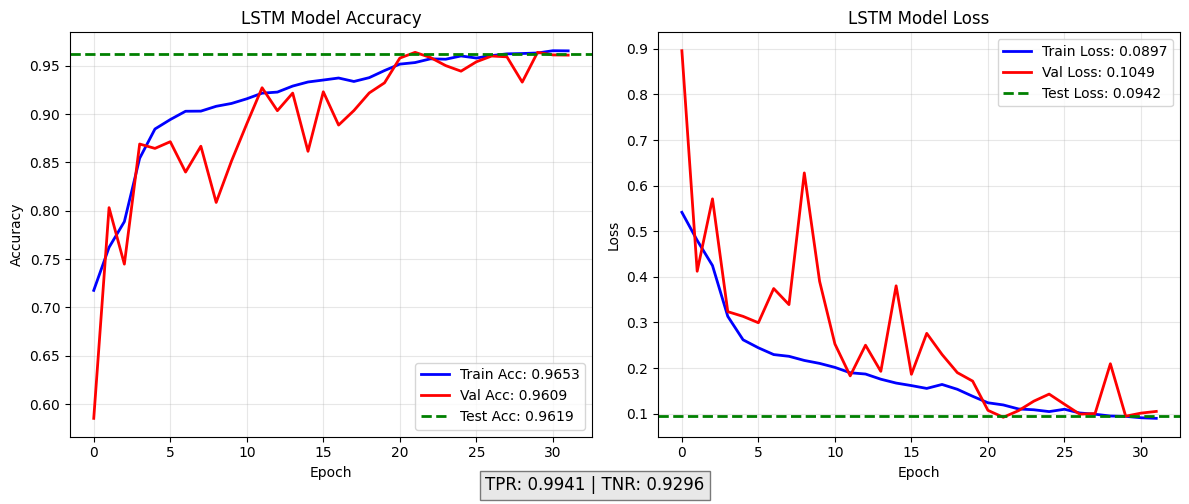


DISTINGUISHER EVALUATION
 DISTINGUISHER FOUND
Training Accuracy: 0.9653
Test Accuracy: 0.9619
Threshold (1/2): 0.5000


In [5]:
%run '/content/drive/MyDrive/Colab Notebooks/ROUND_3/LSTM.ipynb'
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from data_processor import load_and_prepare_data
from sklearn.metrics import confusion_matrix

# Configuration
DATA_FILENAME = 'ascon_dataset_3.csv'
DATA_ROUNDS = 3
DISTINGUISHER_THRESHOLD = 0.50
EPOCHS = 60
BATCH_SIZE = 48
INITIAL_LR = 0.0006
N_INPUT_DIFFERENCES = 2  # Number of input differences considered

def build_lstm_distinguisher(input_length: int) -> Model:

    input_layer = Input(shape=(input_length, 1))

    # First Unidirectional LSTM layer
    x = LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(input_layer)
    x = BatchNormalization()(x)

    # Second LSTM layer
    x = LSTM(32, dropout=0.1, recurrent_dropout=0.1)(x)
    x = BatchNormalization()(x)

    # dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(
        optimizer=Adam(learning_rate=INITIAL_LR),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def calculate_tpr_tnr(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    TPR = TP / (TP + FN)  # Sensitivity, Recall
    TNR = TN / (TN + FP)  # Specificity

    return TPR, TNR

def plot_simple_training_history(history, test_accuracy, test_loss, tpr, tnr):
    """
    Plot only accuracy and loss graphs with TPR/TNR values
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Get final training accuracy and loss
    final_train_accuracy = history.history['accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label=f'Train Acc: {final_train_accuracy:.4f}', linewidth=2, color='blue')
    ax1.plot(history.history['val_accuracy'], label=f'Val Acc: {final_val_accuracy:.4f}', linewidth=2, color='red')
    ax1.axhline(y=test_accuracy, color='green', linestyle='--', linewidth=2, label=f'Test Acc: {test_accuracy:.4f}')
    ax1.set_title('LSTM Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label=f'Train Loss: {final_train_loss:.4f}', linewidth=2, color='blue')
    ax2.plot(history.history['val_loss'], label=f'Val Loss: {final_val_loss:.4f}', linewidth=2, color='red')
    ax2.axhline(y=test_loss, color='green', linestyle='--', linewidth=2, label=f'Test Loss: {test_loss:.4f}')
    ax2.set_title('LSTM Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Add TPR and TNR as text on the plot
    plt.figtext(0.5, 0.01, f'TPR: {tpr:.4f} | TNR: {tnr:.4f}',
                ha='center', fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

    plt.savefig('lstm_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_lstm_distinguisher():
    """Run LSTM distinguisher experiment."""

    print("Loading data for LSTM...")
    X_train, X_val, X_test, Y_train, Y_val, Y_test, input_len, _ = load_and_prepare_data(DATA_FILENAME)

    print(f"\nBuilding  LSTM model for sequence length: {input_len}")
    model = build_lstm_distinguisher(input_len)

    print("\nModel Summary:")
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
        ModelCheckpoint('best_lstm.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]

    print("\nTraining LSTM model...")
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    best_model = tf.keras.models.load_model('best_lstm.keras')
    test_results = best_model.evaluate(X_test, Y_test, verbose=0)
    test_loss, test_accuracy = test_results[0], test_results[1]

    # Predictions for TPR/TNR calculation
    y_pred = best_model.predict(X_test, verbose=0)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate TPR and TNR
    tpr, tnr = calculate_tpr_tnr(Y_test, y_pred_binary)

    # Plot only the simplified graphs
    plot_simple_training_history(history, test_accuracy, test_loss, tpr, tnr)

    # Distinguisher found/not found logic
    print("\n" + "="*60)
    print("DISTINGUISHER EVALUATION")
    print("="*60)

    # Get final training accuracy from history
    final_train_accuracy = history.history['accuracy'][-1]

    if final_train_accuracy > 1/N_INPUT_DIFFERENCES:
        if test_accuracy > 1/N_INPUT_DIFFERENCES:
            print(" DISTINGUISHER FOUND")
        else:
            print(" DISTINGUISHER NOT FOUND")
    else:
        print(" DISTINGUISHER NOT FOUND")

    print(f"Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Threshold (1/{N_INPUT_DIFFERENCES}): {1/N_INPUT_DIFFERENCES:.4f}")
    print("="*60)

if __name__ == '__main__':
    run_lstm_distinguisher()